<p style="text-align:center">
PSY 381D <b>Brain Connectivity</b>, Spring 2019


<img style="width: 700px; padding: 0px;" src="https://github.com/sathayas/JupyterConnectivitySpring2019/blob/master/Images/Banner.png?raw=true" alt="title pics"/>

</p>

<p style="text-align:center; font-size:40px; margin-bottom: 30px;"><b> fMRI pre-processing </b></p>

<p style="text-align:center; font-size:18px; margin-bottom: 32px;"><b>April 15, 2019</b></p>

<hr style="height:5px;border:none" />

# 1. Data
<hr style="height:1px;border:none" />

For today's exercise, we use 3 resting-state fMRI data sets (and their derivative files).
* Oxford, `sub16112`
* Queensland, `sub66095`
* NewYork, `sub83453`

All the files generated from these subjects are found in the **`DatafMRIPreprop`** directory.

# 2. fMRI pre-processing steps
<hr style="height:1px;border:none" />

fMRI data pre-processing steps involved in construction of functional connectivity networks are very similar to pre-processing steps for conventional fMRI studies to examine activations. Here is a summary comparing pre-processing steps between activation fMRI studies and fMRI network construction.

<table>
  <tr>
      <th style="text-align: center"><b>Step</b></th>
      <th style="text-align: left"><b>fMRI activation</b></th>
      <th style="text-align: left"><b>fMRI network</b></th>
  </tr>
  <tr>
    <td style="text-align: center">1</td>
    <td style="text-align: left">Motion correction</td> 
    <td style="text-align: left">Motion correction</td>
  </tr>
  <tr>
    <td style="text-align: center">2</td>
    <td style="text-align: left">Co-registration to T1</td> 
    <td style="text-align: left">Co-registration to T1</td>
  </tr>
  <tr>
    <td style="text-align: center">3</td>
    <td style="text-align: left">Normalization to template</td> 
    <td style="text-align: left">Normalization to template</td>
  </tr>
  <tr>
    <td style="text-align: center">4</td>
    <td style="text-align: left; color:blue">Spatial smoothing</td> 
    <td style="text-align: left">Band-pass filtering</td>
  </tr>
  <tr>
    <td style="text-align: center">5</td>
    <td style="text-align: left">Band-pass filtering</td> 
    <td style="text-align: left; color:red">Global signal regression</td>
  </tr>
  <tr>
    <td style="text-align: center">6</td>
    <td style="text-align: left"> </td> 
    <td style="text-align: left; color:red">Motion scrubbing</td>
  </tr>
</table>

<p style="text-align: center; color:blue; margin-top: 30px; font-size: 10px">Blue: steps specific to fMRI activation analysis</p>
<p style="text-align: center; color:red; margin-top: 0px; font-size: 10px">Red: steps specific to fMRI network analysis</p>

Today, we will focus on pre-processing steps that are unique to fMRI network analysis.

# 3. Global signal regression
<hr style="height:1px;border:none" />

In this step, 6 motion parameters (3 parameters for rotations, and 3 parameters for translations) are regressed out from fMRI data. While this is not unique for some fMRI activation studies where subject motion is of concern, regressing out motion parameters is routinely done in fMRI pre-processing for network construction.

In addition, global mean signals (from the brain parenchyma, deep white matter, and CSF) are also regressed out. To see the reason why such **global signal regression** (**GSR**) is necessary, we can take a look at the ROI time series without and with GSR. We use Oxford **`sub16112`** for this demonstration.

`<PlotTimeSeries.py>`

In [1]:
%matplotlib inline

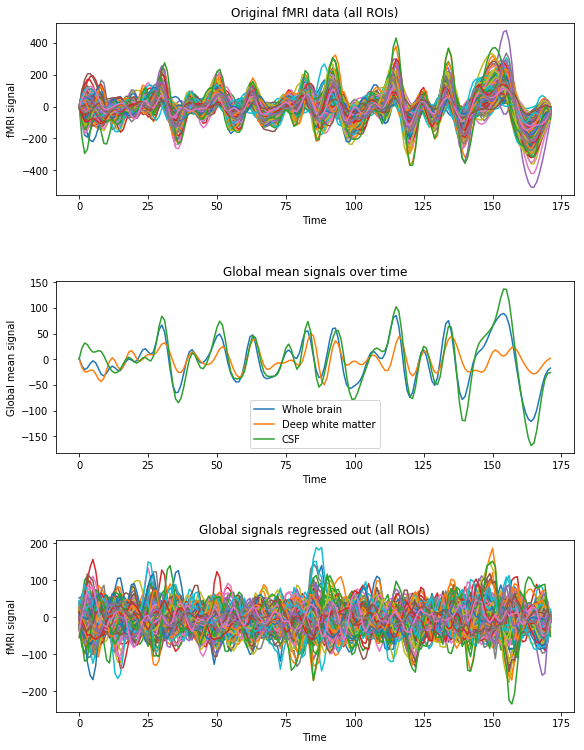

In [2]:
import numpy as np
import matplotlib.pyplot as plt


##### File business
fTS = 'DatafMRIPreprop/Oxford_sub16112_Rt2_K200.npz'
fTS_reg = 'DatafMRIPreprop/Oxford_sub16112_WBWMCSF_Rt2_K200.npz'
fGlobalMean = 'DatafMRIPreprop/Oxford_sub16112_PhysPar.npz'


##### Loading the data
X_TS = np.load(fTS)['ts']
X_GM = np.load(fGlobalMean)['PhysPar']
X_TS_reg = np.load(fTS_reg)['ts']


##### plotting
plt.figure(figsize=[9,11])

plt.subplot(311)
plt.plot(X_TS)
plt.xlabel('Time')
plt.ylabel('fMRI signal')
plt.title('Original fMRI data (all ROIs)')

plt.subplot(312)
plt.plot(X_GM[:,0], label='Whole brain')
plt.plot(X_GM[:,1], label='Deep white matter')
plt.plot(X_GM[:,2], label='CSF')
plt.xlabel('Time')
plt.ylabel('Global mean signal')
plt.title('Global mean signals over time')
plt.legend()

plt.subplot(313)
plt.plot(X_TS_reg)
plt.xlabel('Time')
plt.ylabel('fMRI signal')
plt.title('Global signals regressed out (all ROIs)')

plt.subplots_adjust(left=0.15, right=0.95, bottom=0.08, top=0.95,
                    hspace=0.5)
plt.show()


As you can see, pretty much all ROI time series are correlated with global mean signals. This is because some physiological signals (especially respiration and associated BOLD signal changes) are still present in fMRI data. To lessen the impact of these confounding signals, the global mean signals are regressed out. The resulting time series data are much less confounded by these global signals.

People have different opinions about what global signal should be regressed out (whole brain parenchyma, white matter, and CSF, or some combinations thereof). 

`<ShowImages.py>`

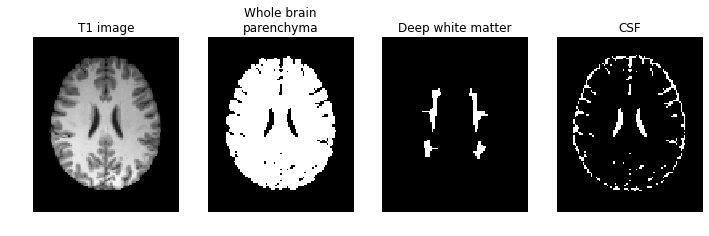

In [6]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt


###### functions to display 3D image
def show_plane(x, nameCmap='gray'):
    '''
    Function to show a slice (provided as a 2D array)
    '''
    plt.imshow(x, cmap=nameCmap)
    plt.gca().set_axis_off()


def show_section(xImg, section, xSlice, nameCmap='gray'):
    '''
    Function to return a 2D array of a slice from a 3D array.
    Slice orientation can be specified by the user.
    '''
    if section=='xy':
        tmpImg = xImg[:,:,xSlice]
    elif section=='xz':
        tmpImg = xImg[:,xSlice,:]
    else:
        tmpImg = xImg[xSlice,:,:]
    show_plane(np.rot90(tmpImg),nameCmap)



###### Loading images
f_T1 = 'DatafMRIPreprop/Oxford_sub16112_T1.nii.gz'
f_WB = 'DatafMRIPreprop/Oxford_sub16112_WB.nii.gz'
f_WM = 'DatafMRIPreprop/Oxford_sub16112_WM.nii.gz'
f_CSF = 'DatafMRIPreprop/Oxford_sub16112_CSF.nii.gz'
X_T1 = nib.load(f_T1).get_data()
X_WB = nib.load(f_WB).get_data()
X_WM = nib.load(f_WM).get_data()
X_CSF = nib.load(f_CSF).get_data()




##### showing images
zSlice = 48
plt.figure(figsize=[12,4])

plt.subplot(141)
show_section(X_T1,'xy',zSlice)
plt.title('T1 image')

plt.subplot(142)
show_section(X_WB,'xy',zSlice)
plt.title('Whole brain\nparenchyma')

plt.subplot(143)
show_section(X_WM,'xy',zSlice)
plt.title('Deep white matter')

plt.subplot(144)
show_section(X_CSF,'xy',zSlice)
plt.title('CSF')
plt.show()



Some proponents of GSR argue that correcting all these signals removes all underlying confounding signals. Some critics of GSR argue that removing these signals artificially introduces anti-correlations (or negative correlations). Let's examine the distribution of correlation coefficients resulting from fMRI without GSR, with full GSR (whole brain, white matter & CSF), as well as with partial GSR (white matter & CSF; a popular combination).

`<Histogram.py>`

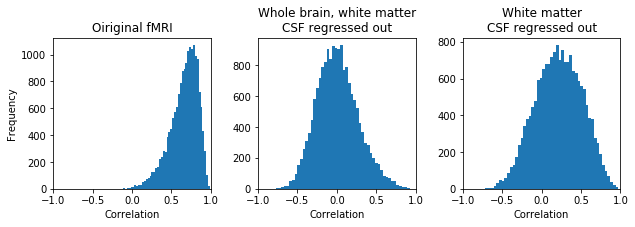

In [3]:
import numpy as np
import matplotlib.pyplot as plt

###### Loading the time series data
fTS = 'DatafMRIPreprop/Oxford_sub16112_Rt2_K200.npz'
fTS_WBWMCSF = 'DatafMRIPreprop/Oxford_sub16112_WBWMCSF_Rt2_K200.npz'
fTS_WMCSF = 'DatafMRIPreprop/Oxford_sub16112_WMCSF_Rt2_K200.npz'
TS = np.load(fTS)['ts']
TS_WBWMCSF = np.load(fTS_WBWMCSF)['ts']
TS_WMCSF = np.load(fTS_WMCSF)['ts']
nNode = TS.shape[-1]


####### Calculating the correlation matrices
R = np.corrcoef(TS, rowvar=False)
R_WBWMCSF = np.corrcoef(TS_WBWMCSF, rowvar=False)
R_WMCSF = np.corrcoef(TS_WMCSF, rowvar=False)

# zeroing the main diagonal
R[np.arange(nNode), np.arange(nNode)] = 0
R_WBWMCSF[np.arange(nNode), np.arange(nNode)] = 0
R_WMCSF[np.arange(nNode), np.arange(nNode)] = 0


###### Histograms of the correlation matrices
nBin = 50
plt.figure(figsize=[9,3])

plt.subplot(131)
plt.hist(R[np.triu_indices(nNode,1)], nBin)
plt.xlim(-1,1)
plt.xlabel('Correlation')
plt.ylabel('Frequency')
plt.title('Oiriginal fMRI')

plt.subplot(132)
plt.hist(R_WBWMCSF[np.triu_indices(nNode,1)], nBin)
plt.xlim(-1,1)
plt.xlabel('Correlation')
plt.title('Whole brain, white matter\nCSF regressed out')

plt.subplot(133)
plt.hist(R_WMCSF[np.triu_indices(nNode,1)], nBin)
plt.xlim(-1,1)
plt.xlabel('Correlation')
plt.title('White matter\nCSF regressed out')


plt.subplots_adjust(left=0.1, right=0.975, bottom=0.15, top=0.85,
                    wspace=0.3, hspace=0.4)
plt.show()



As you can see, without GSR, correlations are highly skewed to the right, with most correlations being positive. With a full GSR, the distribution of correlations is centered at zero. With a partial GSR (white matter & CSF), the distribution of correlations is still skewed to the right, with the majority of correlations still positive.

What would be the impact of these differences in the distribution of correlations? We can examine the networks resulting from these three approaches. These networks are formed to have the average degree of 20.

`<ModulesGSR.py>`

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


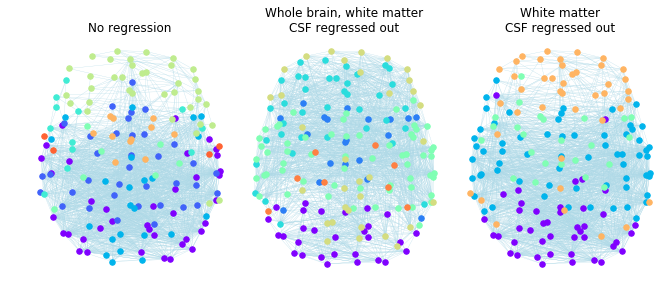

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import community   # Louvain method

# ROI IDs
# Left precentral gyrus: 50
# Left post-cingulate, precuneus: 174

##### Custom distinct color function --- to be used later
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)


####### Loading the network data
fTS = 'DatafMRIPreprop/Oxford_sub16112_Rt2_K200.npz'
nodes = np.load(fTS)['nodes']
xyz = np.load(fTS)['xyz']
fG = 'DatafMRIPreprop/Oxford_sub16112_Rt2_K200_deg20.adjlist'
fG_WBWMCSF = 'DatafMRIPreprop/Oxford_sub16112_WBWMCSF_Rt2_K200_deg20.adjlist'
fG_WMCSF = 'DatafMRIPreprop/Oxford_sub16112_WMCSF_Rt2_K200_deg20.adjlist'
G = nx.read_adjlist(fG, nodetype=int)
G_WBWMCSF = nx.read_adjlist(fG_WBWMCSF, nodetype=int)
G_WMCSF = nx.read_adjlist(fG_WMCSF, nodetype=int)
G_list = [G, G_WBWMCSF, G_WMCSF]
netLabel = ['No regression',
            'Whole brain, white matter\nCSF regressed out',
            'White matter\nCSF regressed out']


####### Finding the giant component and modular partition
partition_list = []
GC_list = []
for iG in G_list:
    # finding the giant component
    GC_nodes = max(nx.connected_components(iG), key=len)  
    GC = iG.subgraph(GC_nodes)
    GC_list.append(iG)
    ###### modular partition by Louvain
    partition = community.best_partition(GC)
    partition_list.append(partition)



###### drawing the graph
# dictionary of xy-coordinates
pos = {}
for iROI in range(len(nodes)):
    pos[nodes[iROI]] = xyz[iROI,:2]

# Loop over states for visualization
plt.figure(figsize=[9,4])
for i,iGC in enumerate(GC_list):
    
    # finally, graph with communities in different colors (Louvain)
    plt.subplot(1,3,i+1)
    nComm = max([comm for comm in partition_list[i].values()])+1
    node_color_list = get_cmap(nComm+1,'rainbow')
    for iComm in range(nComm):
        nodeList = [iNode for iNode,Comm in partition_list[i].items()
                    if Comm==iComm]
        nx.draw_networkx_nodes(iGC, pos, 
                               nodelist=nodeList,
                               node_color = np.array([node_color_list(iComm)]),
                               node_size=30)
    nx.draw_networkx_edges(iGC, pos, width=0.25,
                           edge_color='lightblue')
    plt.title(netLabel[i])
    plt.axis('off')

plt.subplots_adjust(left=0.01, right=0.99, wspace=0.05,
                    bottom=0.025, top=0.85)
plt.show()

Without GSR, what you would likely see is a network of blood supplies into the brain. This is because fMRI signals are highly contaminated with physiological noises. You may notice right away that edges are not evenly distributed throughout the brain.

With a full GSR, edges seem to be evenly distributed throughout the brain, without areas of dense or sparse connectivity. 

With a partial GSR, the resulting network appears to fall somewhere between these two schemes.

In the figure above, different modules (found by the Louvain method) are denoted by different colors. We can some differences in some of the modules. For example, in these networks, the sensory motor (SM) module is represented as

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


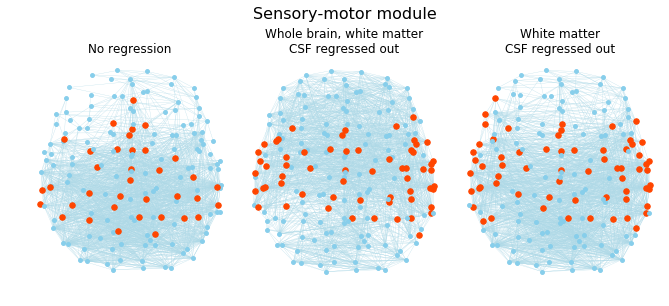

In [7]:
###### drawing the graph (SM module)
# Identifying SM module for each network
ROI_SM = 50  # ROI=50 --> Left precentral gyrus
indSM_list = []
for iMod in partition_list:
    indSM_list.append(iMod[ROI_SM])
    
# Loop over states for visualization
plt.figure(figsize=[9,4])
for i,iGC in enumerate(GC_list):
    
    # finally, graph with communities in different colors (Louvain)
    plt.subplot(1,3,i+1)
    nComm = max([comm for comm in partition_list[i].values()])+1
    for iComm in range(nComm):
        nodeList = [iNode for iNode,Comm in partition_list[i].items()
                    if Comm==iComm]
        if iComm==indSM_list[i]:
            nx.draw_networkx_nodes(iGC, pos, 
                                   nodelist=nodeList,
                                   node_color = 'orangered',
                                   node_size=30)
        else:
            nx.draw_networkx_nodes(iGC, pos, 
                                   nodelist=nodeList,
                                   node_color = 'skyblue',
                                   node_size=15)
            
    nx.draw_networkx_edges(iGC, pos, width=0.25,
                           edge_color='lightblue')
    plt.title(netLabel[i])
    plt.axis('off')

plt.suptitle('Sensory-motor module', size=16)
plt.subplots_adjust(left=0.01, right=0.99, wspace=0.05,
                    bottom=0.025, top=0.8)
plt.show()

And the default mode network (DMN) module.

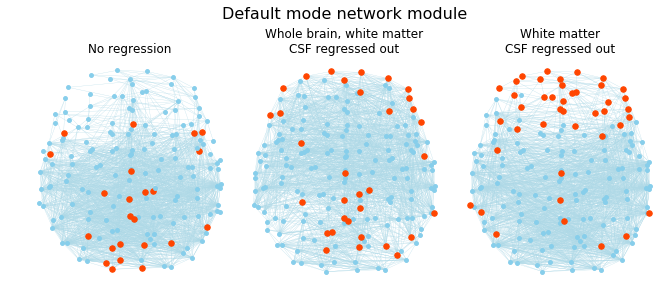

In [8]:
###### drawing the graph (DMN module)
# Identifying DMN module for each network
ROI_DMN = 174  # ROI=174 --> Left posterior cingulate / precuneus
indDMN_list = []
for iMod in partition_list:
    indDMN_list.append(iMod[ROI_DMN])
    
# Loop over states for visualization
plt.figure(figsize=[9,4])
for i,iGC in enumerate(GC_list):
    
    # finally, graph with communities in different colors (Louvain)
    plt.subplot(1,3,i+1)
    nComm = max([comm for comm in partition_list[i].values()])+1
    for iComm in range(nComm):
        nodeList = [iNode for iNode,Comm in partition_list[i].items()
                    if Comm==iComm]
        if iComm==indDMN_list[i]:
            nx.draw_networkx_nodes(iGC, pos, 
                                   nodelist=nodeList,
                                   node_color = 'orangered',
                                   node_size=30)
        else:
            nx.draw_networkx_nodes(iGC, pos, 
                                   nodelist=nodeList,
                                   node_color = 'skyblue',
                                   node_size=15)
            
    nx.draw_networkx_edges(iGC, pos, width=0.25,
                           edge_color='lightblue')
    plt.title(netLabel[i])
    plt.axis('off')

plt.suptitle('Default mode network module', size=16)
plt.subplots_adjust(left=0.01, right=0.99, wspace=0.05,
                    bottom=0.025, top=0.8)
plt.show()

# 4. Motion scrubbing
<hr style="height:1px;border:none" />

Subjects' head motion is always a concern in an fMRI experiment. It is not unusual to regress out motion parameters (generated during the motion correction step) from the fMRI data to account for subject motion, especially when studying a population in which motion may be problematic (e.g., children, Parkinson's disease patients, etc). 

Motion parameters are routinely regressed out during the pre-processing phase of fMRI network data analysis. Here is an example of motion parameters (here we use Queensland **`sub66095`**). Motion parameters represents rotations (around x-, y-, and z-axes) and translations (shifts in x-, y-, and z-directions). The motion at each time point in fMRI data is determined relative to a reference time point. A reference time point is chosen arbitrarily (e.g., first time point, middle time point). 

`<FD.py>`

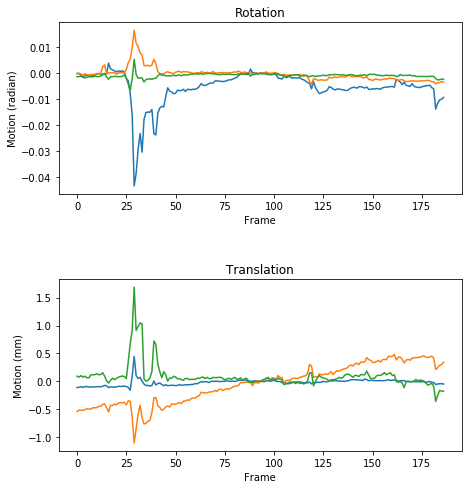

In [11]:
import numpy as np
import matplotlib.pyplot as plt


##### Loading the time series data
fMoPar = 'DatafMRIPreprop/Queensland_sub66095_MoPar.par'
MoPar = np.genfromtxt(fMoPar,
                      delimiter="  ",
                      missing_values=["NA"])
NScan = MoPar.shape[0]

##### plotting the motion parameters
plt.figure(figsize=[7,7])

plt.subplot(211)
for iPar in range(3):
    plt.plot(MoPar[:,iPar])
plt.xlabel('Frame')
plt.ylabel('Motion (radian)')
plt.title('Rotation')

plt.subplot(212)
for iPar in range(3,6):
    plt.plot(MoPar[:,iPar])
plt.xlabel('Frame')
plt.ylabel('Motion (mm)')
plt.title('Translation')

plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.1,
                    hspace=0.5)
plt.show()

As you can see, this particular subject had a large motion around time point 30. Such abrupt motion may be problematic as it can introduce signal drop and artifacts. To identify abrupt motion, it is easier to examine the differences in motion parameters (i.e., t - (t-1)).  

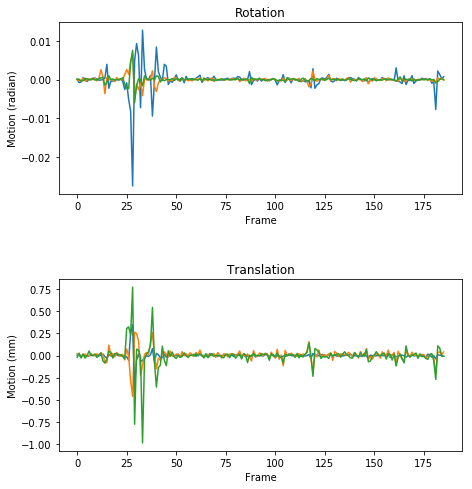

In [13]:
##### plotting changes in motion parameters
dMoPar = np.diff(MoPar, axis=0)
plt.figure(figsize=[7,7])

plt.subplot(211)
for iPar in range(3):
    plt.plot(dMoPar[:,iPar])
plt.xlabel('Frame')
plt.ylabel('Motion (radian)')
plt.title('Rotation')

plt.subplot(212)
for iPar in range(3,6):
    plt.plot(dMoPar[:,iPar])
plt.xlabel('Frame')
plt.ylabel('Motion (mm)')
plt.title('Translation')

plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.1,
                    hspace=0.5)
plt.show()

This way, you can identify time frames for abrupt motion more easily. Although there are 6 motion parameters, it it possible to summarize all these into a single parameter known as **framewise displacement** (FD). FD is the squared sum of the relative motion (i.e., t - (t-1)) parameters. It is very common to remove time frames with high FD (typically FD>0.5). Not only the time points with large FD, but some time points prior and after such motion are often removed. Here, I am plotting FD. Any time points with FD>0.5 are to be deleted, as well as one time point prior to that and two time points following that. The red dots show the time frames to be deleted, a process known as **motion scrubbing**. 

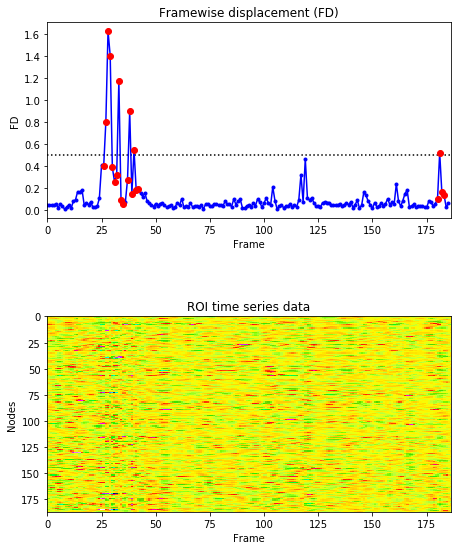

In [16]:
##### Framewise displacement
FD = np.sum(abs(dMoPar), axis=1)


##### tagging frames to be deleted (1 prior, 2 following)
bDelete = np.zeros_like(FD)
for iFrame in range(len(FD)):
    if FD[iFrame]>0.5:
        for jFrame in range(iFrame-1, min(len(FD), iFrame+3)):
            bDelete[jFrame] = 1
        

##### Plotting
plt.figure(figsize=[7,8])

plt.subplot(211)
tFrames = np.arange(len(FD))
plt.plot(tFrames, FD, 'b.-')
plt.plot(tFrames[bDelete==1], FD[bDelete==1], 'ro')
plt.hlines(0.5, 0, len(FD), linestyles='dotted')
plt.xlim(0,len(FD))
plt.xlabel('Frame')
plt.ylabel('FD')
plt.title('Framewise displacement (FD)')

# loading the original time series
fTS = 'DatafMRIPreprop/Queensland_sub66095_Rt2_K200.npz'
ts = np.load(fTS)['ts']
plt.subplot(212)
plt.imshow(ts.T, cmap=plt.cm.gist_ncar, aspect='auto')
plt.xlim(0,len(FD))
plt.xlabel('Frame')
plt.ylabel('Nodes')
plt.title('ROI time series data')

plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.1,
                    hspace=0.5)
plt.show()

### Exercise
**Motion parameters, NewYork sub83453**. In the **`DatafMRIPreprop`** directory, there is a motion parameter file for New York `sub83453` (**`NewYork_sub83453_MoPar.par`**). Plot the rotation and translation parameters for this subject.
**FD, NewYork sub83453**. On the same subject, calculate framewise displacements (FD), and identify volumes to be deleted due to subject motion. The criterion for removal is FD>0.5. One point prior and two points after the time point meeting the criteria also need to be deleted. Determine the total number of of time points to be deleted for this subject.

You may ask, why is subject motion such a big deal? Well, here are the networks generated from fMRI data without and with motion scrubbing.

`<ModulesMS.py>`

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


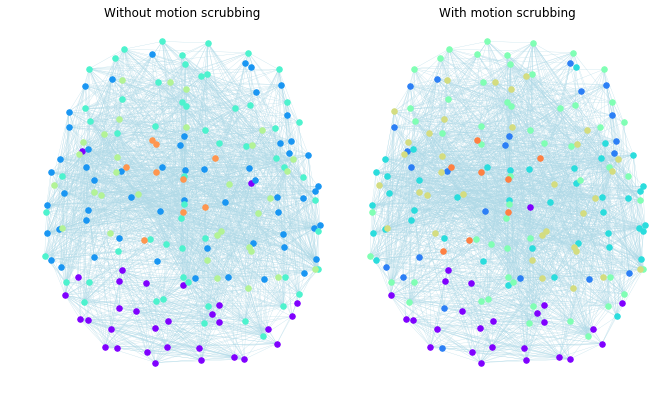

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import community   # Louvain method

# ROI IDs
# Left precentral gyrus: 50
# Left post-cingulate, precuneus: 174

##### Custom distinct color function --- to be used later
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)


####### Loading the network data
fTS = 'DatafMRIPreprop/NewYork_sub83453_Rt2_K200.npz'
nodes = np.load(fTS)['nodes']
xyz = np.load(fTS)['xyz']
fG = 'DatafMRIPreprop/NewYork_sub83453_Rt2_K200_deg20.adjlist'
fG_ms = 'DatafMRIPreprop/NewYork_sub83453_ms_Rt2_K200_deg20.adjlist'
G = nx.read_adjlist(fG, nodetype=int)
G_ms = nx.read_adjlist(fG_ms, nodetype=int)
G_list = [G, G_ms]
netLabel = ['Without motion scrubbing',
            'With motion scrubbing']


####### Finding the giant component and modular partition
partition_list = []
GC_list = []
for iG in G_list:
    # finding the giant component
    GC_nodes = max(nx.connected_components(iG), key=len)  
    GC = iG.subgraph(GC_nodes)
    GC_list.append(iG)
    ###### modular partition by Louvain
    partition = community.best_partition(GC)
    partition_list.append(partition)



###### drawing the graph
# dictionary of xy-coordinates
pos = {}
for iROI in range(len(nodes)):
    pos[nodes[iROI]] = xyz[iROI,:2]

# Loop over states for visualization
plt.figure(figsize=[9,6])
for i,iGC in enumerate(GC_list):
    
    # finally, graph with communities in different colors (Louvain)
    plt.subplot(1,2,i+1)
    nComm = max([comm for comm in partition_list[i].values()])+1
    node_color_list = get_cmap(nComm+1,'rainbow')
    for iComm in range(nComm):
        nodeList = [iNode for iNode,Comm in partition_list[i].items()
                    if Comm==iComm]
        nx.draw_networkx_nodes(iGC, pos, 
                               nodelist=nodeList,
                               node_color = np.array([node_color_list(iComm)]),
                               node_size=30)
    nx.draw_networkx_edges(iGC, pos, width=0.25,
                           edge_color='lightblue')
    plt.title(netLabel[i])
    plt.axis('off')

plt.subplots_adjust(left=0.01, right=0.99, wspace=0.05,
                    bottom=0.025, top=0.85)
plt.show()

You may not notice the difference right away. Let's examine the sensory-motor module from both networks.

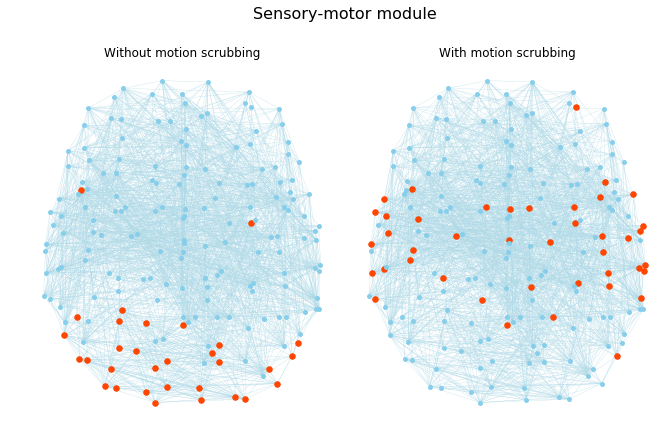

In [19]:
###### drawing the graph (SM module)
# Identifying SM module for each network
ROI_SM = 50  # ROI=50 --> Left precentral gyrus
indSM_list = []
for iMod in partition_list:
    indSM_list.append(iMod[ROI_SM])
    
# Loop over states for visualization
plt.figure(figsize=[9,6])
for i,iGC in enumerate(GC_list):
    
    # finally, graph with communities in different colors (Louvain)
    plt.subplot(1,2,i+1)
    nComm = max([comm for comm in partition_list[i].values()])+1
    for iComm in range(nComm):
        nodeList = [iNode for iNode,Comm in partition_list[i].items()
                    if Comm==iComm]
        if iComm==indSM_list[i]:
            nx.draw_networkx_nodes(iGC, pos, 
                                   nodelist=nodeList,
                                   node_color = 'orangered',
                                   node_size=30)
        else:
            nx.draw_networkx_nodes(iGC, pos, 
                                   nodelist=nodeList,
                                   node_color = 'skyblue',
                                   node_size=15)
            
    nx.draw_networkx_edges(iGC, pos, width=0.25,
                           edge_color='lightblue')
    plt.title(netLabel[i])
    plt.axis('off')

plt.suptitle('Sensory-motor module', size=16)
plt.subplots_adjust(left=0.01, right=0.99, wspace=0.05,
                    bottom=0.025, top=0.85)
plt.show()

And the default mode network module.

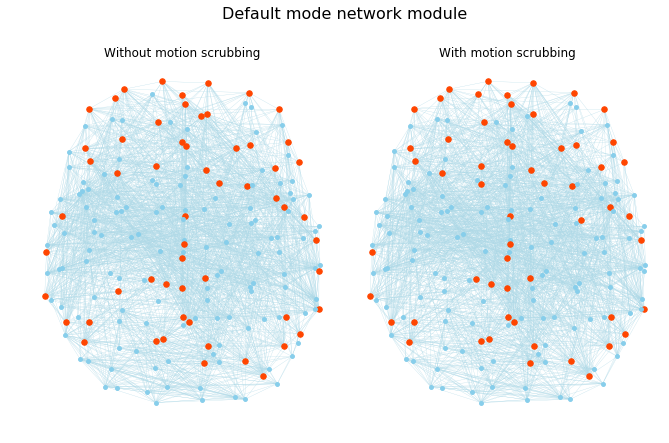

In [21]:
###### drawing the graph (DMN module)
# Identifying DMN module for each network
ROI_DMN = 174  # ROI=174 --> Left posterior cingulate / precuneus
indDMN_list = []
for iMod in partition_list:
    indDMN_list.append(iMod[ROI_DMN])
    
# Loop over states for visualization
plt.figure(figsize=[9,6])
for i,iGC in enumerate(GC_list):
    
    # finally, graph with communities in different colors (Louvain)
    plt.subplot(1,2,i+1)
    nComm = max([comm for comm in partition_list[i].values()])+1
    for iComm in range(nComm):
        nodeList = [iNode for iNode,Comm in partition_list[i].items()
                    if Comm==iComm]
        if iComm==indDMN_list[i]:
            nx.draw_networkx_nodes(iGC, pos, 
                                   nodelist=nodeList,
                                   node_color = 'orangered',
                                   node_size=30)
        else:
            nx.draw_networkx_nodes(iGC, pos, 
                                   nodelist=nodeList,
                                   node_color = 'skyblue',
                                   node_size=15)
            
    nx.draw_networkx_edges(iGC, pos, width=0.25,
                           edge_color='lightblue')
    plt.title(netLabel[i])
    plt.axis('off')

plt.suptitle('Default mode network module', size=16)
plt.subplots_adjust(left=0.01, right=0.99, wspace=0.05,
                    bottom=0.025, top=0.85)
plt.show()

# *Further readings*
<hr style="height:1px;border:none" />

* Power JD et al. 2011. Spurious but systematic correlations in functional connectivity MRI networks arise from subject motion. Neuroimage 59:2142-54 
* Hayasaka S. 2013. Functional connectivity networks with and without global signal correction. Front Hum Neurosci 7: 880
* Fox MD et al. 2006. Spontaneous neuronal activity distinguishes human dorsal and ventral attention systems. PNAS 103:10046–10051.
* Fox MD et al. 2005. The human brain is intrinsically organized into dynamic, anticorrelated functional networks. PNAS 102:9673–9678
* Fox MD et al. 2009. The global signal and observed anticorrelated resting state brain networks. J. Neurophysiol. 101:3270–3283